# Problem 1 - Variational Auto-Encoder (VAE)

Variational Auto-Encoders (VAEs) are a widely used class of generative models. They are simple to implement and, in contrast to other generative model classes like Generative Adversarial Networks (GANs, see Problem 2), they optimize an explicit maximum likelihood objective to train the model. Finally, their architecture makes them well-suited for unsupervised representation learning, i.e., learning low-dimensional representations of high-dimenionsal inputs, like images, with only self-supervised objectives (data reconstruction in the case of VAEs).

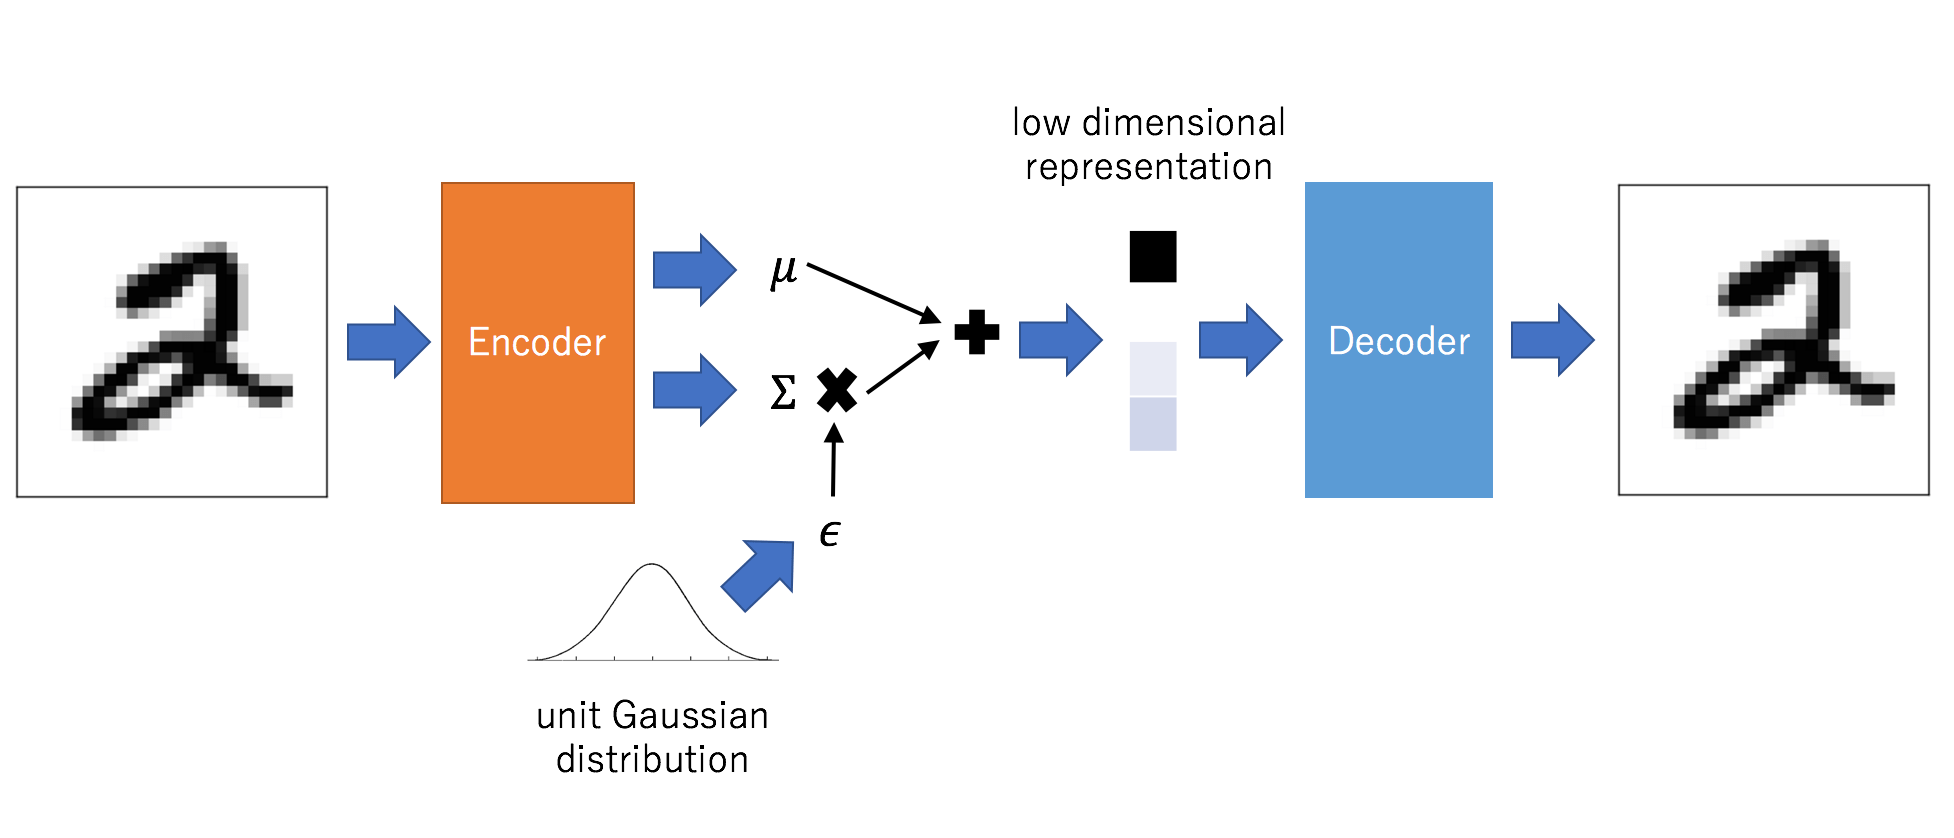
*(image source: https://mlexplained.com/2017/12/28/an-intuitive-explanation-of-variational-autoencoders-vaes-part-1)*

**By working on this problem you will learn and practice the following steps:**
1. Set up a data loading pipeline in PyTorch.
2. Implement, train and visualize an auto-encoder architecture.
3. Extend your implementation to a variational auto-encoder.
4. Learn how to tune the critical beta parameter of your VAE.
5. Inspect the learned representation of your VAE.
6. Extend VAE's generative capabilities by conditioning it on the label you wish to generate.


**Note**: For faster training of the models in this assignment you can enable GPU support in this Colab. Navigate to "Runtime" --> "Change Runtime Type" and set the "Hardware Accelerator" to "GPU". However, you might hit compute limits of the colab free edition. Hence, you might want to debug locally (e.g. in a jupyter notebook) or in a CPU-only runtime on colab.

# 1. MNIST Dataset

We will perform all experiments for this problem using the [MNIST dataset](http://yann.lecun.com/exdb/mnist/), a standard dataset of handwritten digits. The main benefits of this dataset are that it is small and relatively easy to model. It therefore allows for quick experimentation and serves as initial test bed in many papers.

Another benefit is that it is so widely used that PyTorch even provides functionality to automatically download it.

Let's start by downloading the data and visualizing some samples.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torchvision

# if torch.backends.mps.is_available():
#     dev = "mps"
# elif torch.cuda.is_avaliable():
#     dev = "cuda:0"
# else:
#     
dev = "cpu"
device = torch.device(dev)
print(f"Using device: {device}")


# this will automatically download the MNIST training set
mnist_train = torchvision.datasets.MNIST(root='./data', 
                                         train=True, 
                                         download=True, 
                                         transform=torchvision.transforms.ToTensor())
print("\n Download complete! Downloaded {} training examples!".format(len(mnist_train)))

Using device: cpu

 Download complete! Downloaded 60000 training examples!


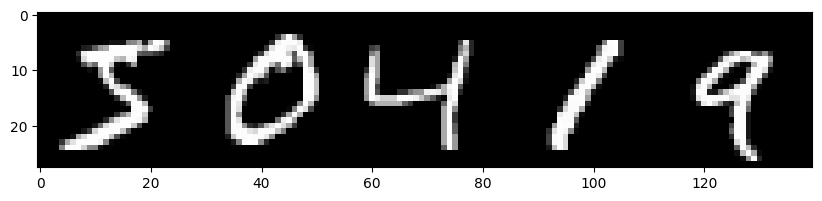

In [3]:
from numpy.random.mtrand import sample
import matplotlib.pyplot as plt
import numpy as np

# Let's display some of the training samples.
sample_images = []
randomize = False # set to False for debugging
num_samples = 5 # simple data sampling for now, later we will use proper DataLoader
if randomize:
  sample_idxs = np.random.randint(low=0,high=len(mnist_train), size=num_samples)
else:
  sample_idxs = list(range(num_samples))

for idx in sample_idxs:
  sample = mnist_train[idx]
  # print(f"Tensor w/ shape {sample[0][0].detach().cpu().numpy().shape} and label {sample[1]}")
  sample_images.append(sample[0][0].data.cpu().numpy())
  # print(sample_images[0]) # Values are in [0, 1]

fig = plt.figure(figsize = (10, 50))   
ax1 = plt.subplot(111)
ax1.imshow(np.concatenate(sample_images, axis=1), cmap='gray')
plt.show()

# 2. Auto-Encoder

Before implementing the full VAE, we will first implement an **auto-encoder architecture**. Auto-encoders feature the same encoder-decoder architecture as VAEs and therefore also learn a low-dimensional representation of the input data without supervision. In contrast to VAEs they are **fully deterministic** models and do not employ variational inference for optimization.

The **architecture** is very simple: we will encode the input image into a low-dimensional representation using fully connected layers for the encoder. This results in a low-dimensional representation of the input image. This representation will get decoded back into the dimensionality of the input image using a decoder network that mirrors the architecture of the encoder. The whole model is trained by **minimizing a reconstruction loss** between the input and the decoded image.

Intuitively, the **auto-encoder needs to compress the information contained in the input image** into a much lower dimensional representation (e.g. 28x28=784px vs. nz embedding dimensions for our MNIST model). This is possible since the information captured in the pixels is *highly redundant*. E.g. encoding an MNIST image requires <4 bits to encode which of the 10 possible digits is displayed and a few additional bits to capture information about shape and orientation. This is much less than the $255^{28\cdot 28}$ bits of information that could be theoretically captured in the input image.

Learning such a **compressed representation can make downstream task learning easier**. For example, learning to add two numbers based on the inferred digits is much easier than performing the task based on two piles of pixel values that depict the digits.

In the following, we will first define the architecture of encoder and decoder and then train the auto-encoder model.

## Defining the Auto-Encoder Architecture [6pt]

In [4]:
import torch.nn as nn

# Prob1-1: Let's define encoder and decoder networks
class Encoder(nn.Module):
  def __init__(self, nz, input_size):
    super().__init__()
    self.input_size = input_size
    ################################# TODO #########################################
    # Create the network architecture using a nn.Sequential module wrapper.        #
    # Encoder Architecture:                                                        #
    # - input_size -> 256                                                          #
    # - ReLU                                                                       #
    # - 256 -> 64                                                                  #
    # - ReLU                                                                       #
    # - 64 -> nz                                                                   #
    # HINT: Verify the shapes of intermediate layers by running partial networks   #
    #        (with the next notebook cell) and visualizing the output shapes.      #
    ################################################################################
    self.net = nn.Sequential(
    nn.Linear(input_size, 256),
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Linear(64, nz))
    ###############
    ################# END TODO #######################################
  
  def forward(self, x):
    return self.net(x)


class Decoder(nn.Module):
  def __init__(self, nz, output_size):
    super().__init__()
    self.output_size = output_size
    ################################# TODO #########################################
    # Create the network architecture using a nn.Sequential module wrapper.        #
    # Decoder Architecture (mirrors encoder architecture):                         #
    # - nz -> 64                                                                   #
    # - ReLU                                                                       #
    # - 64 -> 256                                                                  #
    # - ReLU                                                                       #
    # - 256 -> output_size                                                         #
    ################################################################################
    self.net = nn.Sequential(
    nn.Linear(nz, 64),
    nn.ReLU(),
    nn.Linear(64, 256),
    nn.ReLU(),
    nn.Linear(256, self.output_size),
    nn.Sigmoid())
    ################################ END TODO #######################################
  
  def forward(self, z):
    return self.net(z).reshape(-1, 1, self.output_size)

## Testing the Auto-Encoder Forward Pass

In [5]:
# To test your encoder/decoder, let's encode/decode some sample images
# first, make a PyTorch DataLoader object to sample data batches
batch_size = 64
nworkers = 2        # number of workers used for efficient data loading

####################################################################################
# Create a PyTorch DataLoader object for efficiently generating training batches.  #
# Make sure that the data loader automatically shuffles the training dataset.      #
# Consider only *full* batches of data, to avoid torch errrors.              #
# The DataLoader wraps the MNIST dataset class we created earlier.           #
#       Use the given batch_size and number of data loading workers when creating  #
#       the DataLoader. https://pytorch.org/docs/stable/data.html                  #
####################################################################################
mnist_data_loader = torch.utils.data.DataLoader(mnist_train, 
                                                batch_size=batch_size, 
                                                shuffle=True, 
                                                num_workers=nworkers,
                                                drop_last=True)
####################################################################################

# now we can run a forward pass for encoder and decoder and check the produced shapes
in_size = out_size = 28*28 # image size
nz = 32          # dimensionality of the learned embedding
encoder = Encoder(nz=nz, input_size=in_size)
decoder = Decoder(nz=nz, output_size=out_size)
for sample_img, sample_label in mnist_data_loader: # loads a batch of data
  input = sample_img.reshape([batch_size, in_size])
  print(f'{sample_img.shape=}, {type(sample_img)}, {input.shape=}')
  enc = encoder(input)
  print(f"Shape of encoding vector (should be [batch_size, nz]): {enc.shape}")
  dec = decoder(enc)
  print("Shape of decoded image (should be [batch_size, 1, out_size]): {}.".format(dec.shape))    
  break

del input, enc, dec, encoder, decoder, nworkers # remove to avoid confusion later

sample_img.shape=torch.Size([64, 1, 28, 28]), <class 'torch.Tensor'>, input.shape=torch.Size([64, 784])
Shape of encoding vector (should be [batch_size, nz]): torch.Size([64, 32])
Shape of decoded image (should be [batch_size, 1, out_size]): torch.Size([64, 1, 784]).


Now that we defined encoder and decoder network our architecture is nearly complete. However, before we start training, we can wrap encoder and decoder into an auto-encoder class for easier handling.

In [6]:
class AutoEncoder(nn.Module):
  def __init__(self, nz):
    super().__init__()
    self.encoder = Encoder(nz=nz, input_size=in_size)
    self.decoder = Decoder(nz=nz, output_size=out_size)

  def forward(self, x):
    enc = self.encoder(x)
    return self.decoder(enc)

  def reconstruct(self, x):
    """Only used later for visualization."""
    print(x.shape)
    enc = self.encoder(x)
    print(enc.shape)
    flattened = self.decoder(enc)
    print(flattened.shape)
    image = flattened.reshape(-1, 28, 28)
    return image

## Setting up the Auto-Encoder Training Loop [6pt]
After implementing the network architecture, we can now set up the training loop and run training.

In [7]:
# Prob1-2
epochs = 10
learning_rate = 1e-3

# build AE model
print(f'Device available {device}')
ae_model = AutoEncoder(nz).to(device)    # transfer model to GPU if available
ae_model = ae_model.train()   # set model in train mode (eg batchnorm params get updated)

# build optimizer and loss function
####################################### TODO #######################################
# Build the optimizer and loss classes. For the loss you can use a loss layer      #
# from the torch.nn package. We recommend binary cross entropy.                    #
# HINT: We will use the Adam optimizer (learning rate given above, otherwise       #
#       default parameters).                                                       #
# NOTE: We could also use alternative losses like MSE and cross entropy, depending #
#       on the assumptions we are making about the output distribution.            #
####################################################################################
bce_loss = nn.BCELoss()
optimizer = torch.optim.Adam(ae_model.parameters(), lr=learning_rate)
#################################### END TODO #######################################

train_it = 0
for ep in range(epochs):
  print("Run Epoch {}".format(ep))
  ####################################### TODO #######################################
  # Implement the main training loop for the auto-encoder model.                     #
  # HINT: Your training loop should sample batches from the data loader, run the     #
  #       forward pass of the AE, compute the loss, perform the backward pass and    #
  #       perform one gradient step with the optimizer.                              #
  # HINT: Don't forget to erase old gradients before performing the backward pass.   #
  ####################################################################################
  for sample_img, sample_label in mnist_data_loader:
    optimizer.zero_grad()
    sample_image = sample_img.reshape([batch_size, in_size])
    out = ae_model.forward(sample_image)
    sample_image = sample_image.reshape([batch_size,1, in_size])
    rec_loss = bce_loss(out, sample_image)
    rec_loss.backward()
    optimizer.step()
    if train_it % 100 == 0:
      print("It {}: Reconstruction Loss: {}".format(train_it, rec_loss))
    train_it += 1
  #################################### END TODO #####################################

print("Done!")
del epochs, learning_rate, sample_img, train_it, rec_loss #, opt

Device available cpu
Run Epoch 0
It 0: Reconstruction Loss: 0.6928347945213318
It 100: Reconstruction Loss: 0.26421648263931274
It 200: Reconstruction Loss: 0.22144503891468048
It 300: Reconstruction Loss: 0.18472997844219208
It 400: Reconstruction Loss: 0.15403206646442413
It 500: Reconstruction Loss: 0.1607668399810791
It 600: Reconstruction Loss: 0.1565956026315689
It 700: Reconstruction Loss: 0.14220216870307922
It 800: Reconstruction Loss: 0.1382327824831009
It 900: Reconstruction Loss: 0.1352928876876831
Run Epoch 1
It 1000: Reconstruction Loss: 0.14660733938217163
It 1100: Reconstruction Loss: 0.1376168131828308
It 1200: Reconstruction Loss: 0.12908460199832916
It 1300: Reconstruction Loss: 0.1286795735359192
It 1400: Reconstruction Loss: 0.1265348345041275
It 1500: Reconstruction Loss: 0.13046574592590332
It 1600: Reconstruction Loss: 0.12361937016248703
It 1700: Reconstruction Loss: 0.12083187699317932
It 1800: Reconstruction Loss: 0.1266530454158783
Run Epoch 2
It 1900: Recon

## Verifying reconstructions
Now that we trained the auto-encoder we can visualize some of the reconstructions on the test set to verify that it is converged and did not overfit. **Before continuing, make sure that your auto-encoder is able to reconstruct these samples near-perfectly.**

torch.Size([784])
torch.Size([32])
torch.Size([1, 1, 784])
torch.Size([784])
torch.Size([32])
torch.Size([1, 1, 784])
torch.Size([784])
torch.Size([32])
torch.Size([1, 1, 784])
torch.Size([784])
torch.Size([32])
torch.Size([1, 1, 784])
torch.Size([784])
torch.Size([32])
torch.Size([1, 1, 784])


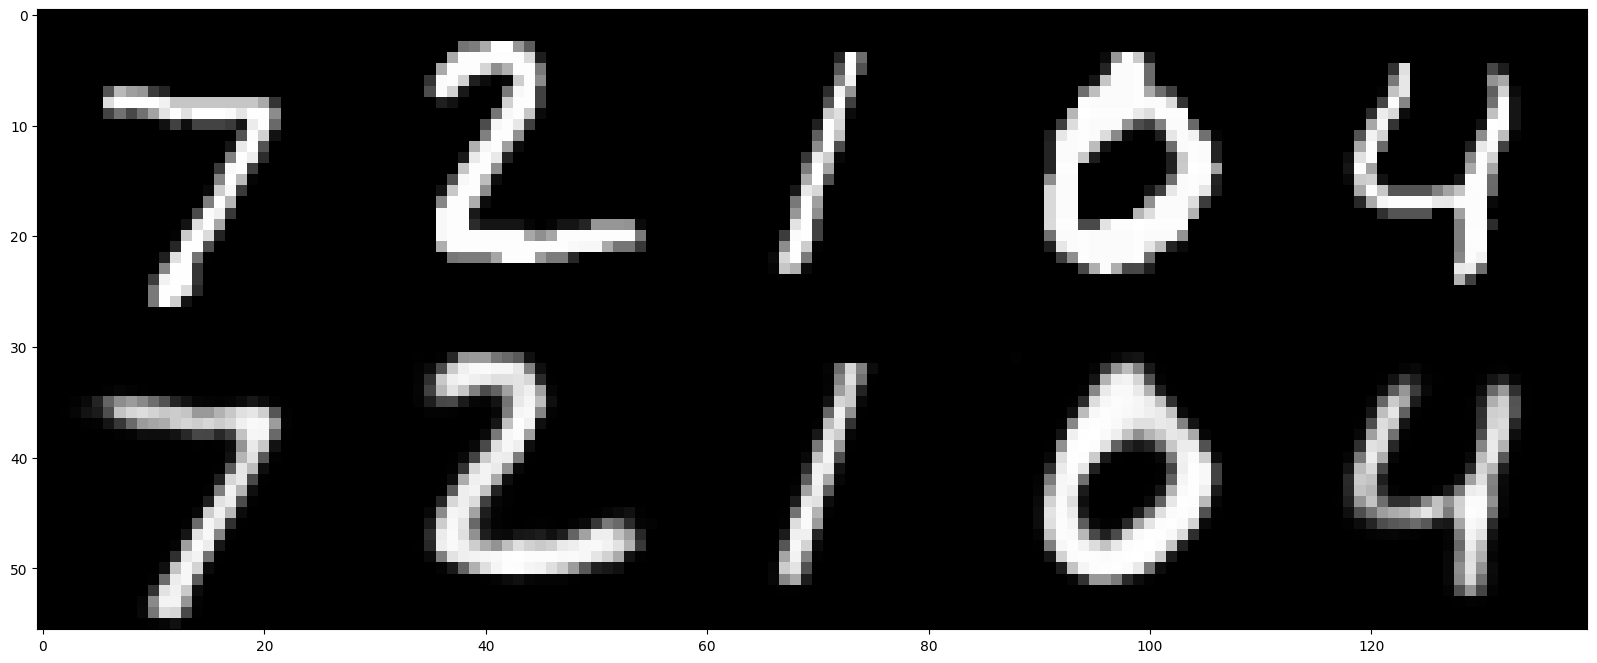

In [8]:
# visualize test data reconstructions
def vis_reconstruction(model, randomize=False):
  # download MNIST test set + build Dataset object
  mnist_test = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          download=True, 
                                          transform=torchvision.transforms.ToTensor())
  model.eval()      # set model in evalidation mode (eg freeze batchnorm params)
  num_samples = 5
  if randomize:
    sample_idxs = np.random.randint(low=0,high=len(mnist_test), size=num_samples)
  else:
    sample_idxs = list(range(num_samples))

  input_imgs, test_reconstructions = [], []
  for idx in sample_idxs:
    sample = mnist_test[idx]
    input_img = np.asarray(sample[0])
    input_flat = input_img.reshape(784)
#     print(input_img.shape, input_flat.shape)
    reconstruction = model.reconstruct(torch.tensor(input_flat, device=device))
    
    input_imgs.append(input_img[0])
    test_reconstructions.append(reconstruction[0].data.cpu().numpy())
    #print(f'{input_img[0].shape=}\t{reconstruction.shape}')

  fig = plt.figure(figsize = (20, 50))   
  ax1 = plt.subplot(111)
  ax1.imshow(np.concatenate([np.concatenate(input_imgs, axis=1),
                            np.concatenate(test_reconstructions, axis=1)], axis=0), cmap='gray')
  plt.show()

vis_reconstruction(ae_model, randomize=False) # set randomize to False for debugging

## Sampling from the Auto-Encoder [2pt]

To test whether the auto-encoder is useful as a generative model, we can use it like any other generative model: draw embedding samples from a prior distribution and decode them through the decoder network. We will choose a unit Gaussian prior to allow for easy comparison to the VAE later.

torch.Size([64, 1, 784])


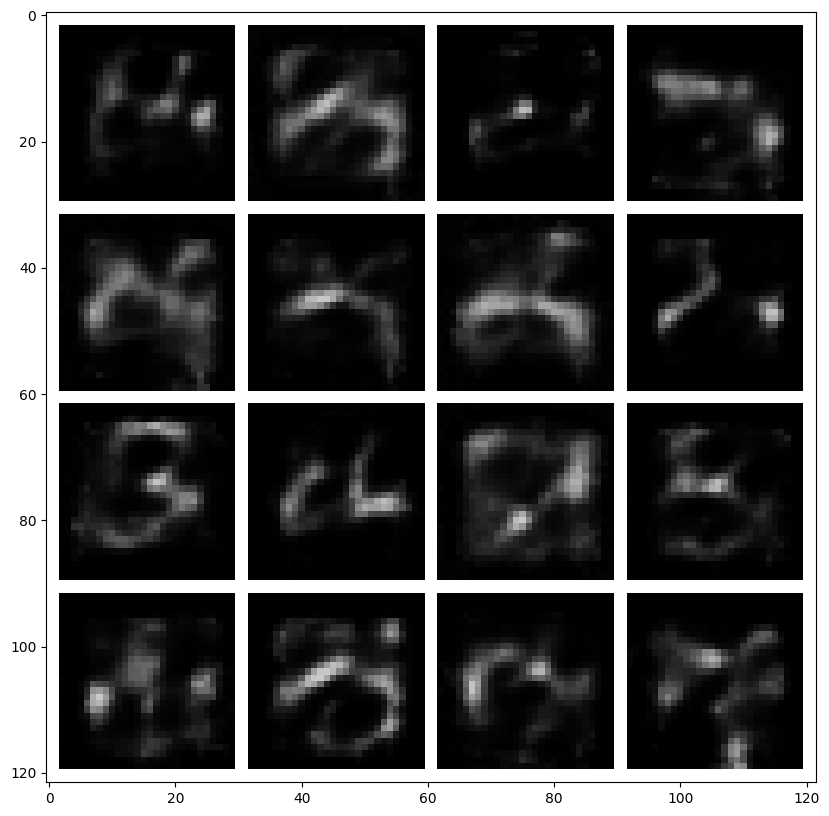

In [9]:
# we will sample N embeddings, then decode and visualize them
def vis_samples(model):
  ####################################### TODO #######################################
  # Prob1-3 Sample embeddings from a diagonal unit Gaussian distribution and decode them #
  # using the model.                                                                 #
  # HINT: The sampled embeddings should have shape [batch_size, nz]. Diagonal unit   #
  #       Gaussians have mean 0 and a covariance matrix with ones on the diagonal    #
  #       and zeros everywhere else.                                                 #
  # HINT: If you are unsure whether you sampled the correct distribution, you can    #
  #       sample a large batch and compute the empirical mean and variance using the #
  #       .mean() and .var() functions.                                              #
  # HINT: You can directly use model.decoder() to decode the samples.                #
  ####################################################################################
#   sample = torch.empty([64,32]).normal(mean= 0, std=torch.arange(1, 0, -0.1))
    z = torch.randn(64,32)
    decoded_samples = model.decoder(z)
    print(decoded_samples.shape)
    decoded_samples = decoded_samples.reshape([64, 1, 28, 28])
  
    
#################################### END TODO ######################################

    fig = plt.figure(figsize = (10, 10))   
    ax1 = plt.subplot(111)
    ax1.imshow(torchvision.utils.make_grid(decoded_samples[:16], nrow=4, pad_value=1.)\
                .data.cpu().numpy().transpose(1, 2, 0), cmap='gray')
    plt.show()

vis_samples(ae_model)


>**Prob1-3 continued: Inline Question: Describe your observations, why do you think they occur? [2pt]** 
>(max 150 words)
>
>**Answer:** 



# 3. Variational Auto-Encoder (VAE)

Variational auto-encoders use a very similar architecture to deterministic auto-encoders, but are inherently storchastic models, i.e. we perform a stochastic sampling operation during the forward pass, leading to different different outputs every time we run the network for the same input. This sampling is required to optimize the VAE objective also known as the evidence lower bound (ELBO):

$$
p(x) > \underbrace{\mathbb{E}_{z\sim q(z\vert x)} p(x \vert z)}_{\text{reconstruction}} - \underbrace{D_{\text{KL}}\big(q(z \vert x), p(z)\big)}_{\text{prior divergence}}
$$

Here, $D_{\text{KL}}(q, p)$ denotes the Kullback-Leibler (KL) divergence between the posterior distribution $q(z \vert x)$, i.e. the output of our encoder, and $p(z)$, the prior over the embedding variable $z$, which we can choose freely.

For simplicity, we will choose a unit Gaussian prior again. The first term is the reconstruction term we already know from training the auto-encoder. When assuming a Gaussian output distribution for both encoder $q(z \vert x)$ and decoder $p(x \vert z)$ the objective reduces to:

$$
\mathcal{L}_{\text{VAE}} = \sum_{x\sim \mathcal{D}} \mathcal{L}_{\text{rec}}(x, \hat{x}) - \beta \cdot D_{\text{KL}}\big(\mathcal{N}(\mu_q, \sigma_q), \mathcal{N}(0, I)\big)
$$

Here, $\hat{x}$ is the reconstruction output of the decoder. In comparison to the auto-encoder objective, the VAE adds a regularizing term between the output of the encoder and a chosen prior distribution, effectively forcing the encoder output to not stray too far from the prior during training. As a result the decoder gets trained with samples that look pretty similar to samples from the prior, which will hopefully allow us to generate better images when using the VAE as a generative model and actually feeding it samples from the prior (as we have done for the AE before).

The coefficient $\beta$ is a scalar weighting factor that trades off between reconstruction and regularization objective. We will investigate the influence of this factor in out experiments below.

If you need a refresher on VAEs you can check out this tutorial paper: https://arxiv.org/abs/1606.05908

### Reparametrization Trick

The sampling procedure inside the VAE's forward pass for obtaining a sample $z$ from the posterior distribution $q(z \vert x)$, when implemented naively, is non-differentiable. However, since $q(z\vert x)$ is parametrized with a Gaussian function, there is a simple trick to obtain a differentiable sampling operator, known as the _reparametrization trick_.

Instead of directly sampling $z \sim \mathcal{N}(\mu_q, \sigma_q)$ we can "separate" the network's predictions and the random sampling by computing the sample as:

$$
z = \mu_q + \sigma_q * \epsilon , \quad \epsilon \sim \mathcal{N}(0, I)
$$

Note that in this equation, the sample $z$ is computed as a deterministic function of the network's predictions $\mu_q$ and $\sigma_q$ and therefore allows to propagate gradients through the sampling procedure.

**Note**: While in the equations above the encoder network parametrizes the standard deviation $\sigma_q$ of the Gaussian posterior distribution, in practice we usually parametrize the **logarithm of the standard deviation** $\log \sigma_q$ for numerical stability. Before sampling $z$ we will then exponentiate the network's output to obtain $\sigma_q$.



## Defining the VAE Model [7pt]

In [24]:
def kl_divergence(mu1, log_sigma1, mu2, log_sigma2):
  """Computes KL[p||q] between two Gaussians defined by [mu, log_sigma]."""
  return (log_sigma2 - log_sigma1) + (torch.exp(log_sigma1) ** 2 + (mu1 - mu2) ** 2) \
               / (2 * torch.exp(log_sigma2) ** 2) - 0.5

# Prob1-4
class VAE(nn.Module):
  def __init__(self, nz, beta=1.0):
    super().__init__()
    self.beta = beta          # factor trading off between two loss components
    ####################################### TODO #######################################
    # Instantiate Encoder and Decoder.                                                 #
    # HINT: Remember that the encoder is now parametrizing a Gaussian distribution's   #
    #       mean and log_sigma, so the dimensionality of the output needs to           #
    #       double. The decoder works with an embedding sampled from this output.  #
    ####################################################################################
    self.encoder = Encoder(nz * 2, input_size=in_size)
    self.decoder = Decoder(nz, output_size=out_size)
    #################################### END TODO ######################################

  def forward(self, x):
    ####################################### TODO #######################################
    # Implement the forward pass of the VAE.                                           #
    # HINT: Your code should implement the following steps:                            #
    #          1. encode input x, split encoding into mean and log_sigma of Gaussian   #
    #          2. sample z from inferred posterior distribution using                  #
    #             reparametrization trick                                              #
    #          3. decode the sampled z to obtain the reconstructed image               #
    ####################################################################################
    x_new = x.reshape([batch_size, in_size])
    encoding = self.encoder(x_new)
    m, sig = encoding[:, :nz], encoding[:, nz:]
    e = torch.rand_like(torch.log(sig))*torch.exp(sig)  
    z = m + e
    rec_out = self.decoder(z)
    reconstruction = rec_out.reshape(x.shape)
    #################################### END TODO ######################################

    return {'q': encoding, 
            'rec': reconstruction}

  def loss(self, x, outputs):
    ####################################### TODO #######################################
    # Implement the loss computation of the VAE.                                       #
    # HINT: Your code should implement the following steps:                            #
    #          1. compute the image reconstruction loss, similar to AE loss above      #
    #          2. compute the KL divergence loss between the inferred posterior        #
    #             distribution and a unit Gaussian prior; you can use the provided     #
    #             function above for computing the KL divergence between two Gaussians #
    #             parametrized by mean and log_sigma                                   #
    # HINT: Make sure to compute the KL divergence in the correct order since it is    #
    #       not symmetric!!  ie. KL(p, q) != KL(q, p)                                  #
    ####################################################################################
    rec, q = outputs['rec'], outputs['q']
    rec_loss = torch.nn.functional.binary_cross_entropy(rec, x)
    m, sig = q[:, :nz],q[:, nz:]
    m1, sig1 = torch.zeros_like(q[:, :nz]), torch.zeros_like(q[:, nz:])
    kl_loss = torch.mean(kl_divergence(m ,sig, m1, sig1))
    #################################### END TODO ######################################

    # return weighted objective
    return rec_loss + self.beta * kl_loss, \
           {'rec_loss': rec_loss, 'kl_loss': kl_loss}
    
  def reconstruct(self, x):
    """Use mean of posterior estimate for visualization reconstruction."""
    ####################################### TODO #######################################
    # This function is used for visualizing reconstructions of our VAE model. To       #
    # obtain the maximum likelihood estimate we bypass the sampling procedure of the   #
    # inferred latent and instead directly use the mean of the inferred posterior.     #
    # HINT: encode the input image and then decode the mean of the posterior to obtain #
    #       the reconstruction.                                                        #
    ####################################################################################
    q = self.encoder(x)
    q = q.reshape(-1, 1, nz)
    reconstruction = self.decoder(q)
    image = reconstruction.reshape(-1, 28, 28)
    #################################### END TODO ######################################
    return image


## Setting up the VAE Training Loop [4pt]

Let's start training the VAE model! We will first verify our implementation by setting $\beta = 0$.


Running 5 epochs with beta=0
Run Epoch 0
It 0: Total Loss: 0.6946018934249878, 	 Rec Loss: 0.6946018934249878,	 KL Loss: 0.009685656987130642
It 100: Total Loss: 0.24943506717681885, 	 Rec Loss: 0.24943506717681885,	 KL Loss: 1.2091035842895508
It 200: Total Loss: 0.23183034360408783, 	 Rec Loss: 0.23183034360408783,	 KL Loss: 1.7323206663131714
It 300: Total Loss: 0.19121399521827698, 	 Rec Loss: 0.19121399521827698,	 KL Loss: 3.7336933612823486
It 400: Total Loss: 0.16001372039318085, 	 Rec Loss: 0.16001372039318085,	 KL Loss: 5.8789286613464355
It 500: Total Loss: 0.16776131093502045, 	 Rec Loss: 0.16776131093502045,	 KL Loss: 7.0488715171813965
It 600: Total Loss: 0.14221327006816864, 	 Rec Loss: 0.14221327006816864,	 KL Loss: 7.4899516105651855
It 700: Total Loss: 0.14617633819580078, 	 Rec Loss: 0.14617633819580078,	 KL Loss: 8.700526237487793
It 800: Total Loss: 0.13385993242263794, 	 Rec Loss: 0.13385993242263794,	 KL Loss: 10.367769241333008
It 900: Total Loss: 0.1381087601184

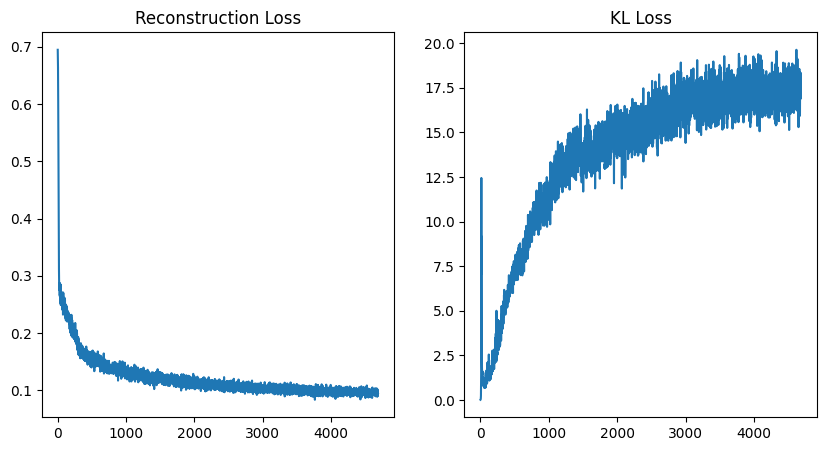

In [25]:
# Prob1-5 VAE training loop
learning_rate = 1e-3
nz = 32
beta = 0

####################################### TODO #######################################
epochs = 5      # recommended 5-20 epochs
#################################### END TODO ######################################

# build VAE model
vae_model = VAE(nz, beta).to(device)    # transfer model to GPU if available
vae_model = vae_model.train()   # set model in train mode (eg batchnorm params get updated)

# build optimizer and loss function
####################################### TODO #######################################
# Build the optimizer for the vae_model. We will again use the Adam optimizer with #
# the given learning rate and otherwise default parameters.                        #
####################################################################################
# same as AE
optimizer = torch.optim.Adam(vae_model.parameters(), lr=learning_rate)
#################################### END TODO ######################################

train_it = 0
rec_loss, kl_loss = [], []
print(f"Running {epochs} epochs with {beta=}")
for ep in range(epochs):
    print("Run Epoch {}".format(ep))
    ####################################### TODO #######################################
    # Implement the main training loop for the VAE model.                              #
    # HINT: Your training loop should sample batches from the data loader, run the     #
    #       forward pass of the VAE, compute the loss, perform the backward pass and   #
    #       perform one gradient step with the optimizer.                              #
    # HINT: Don't forget to erase old gradients before performing the backward pass.   #
    # HINT: This time we will use the loss() function of our model for computing the   #
    #       training loss. It outputs the total training loss and a dict containing    #
    #       the breakdown of reconstruction and KL loss.                               #
    ####################################################################################
    for (sample_image, _) in mnist_data_loader:
        out = vae_model.forward(sample_image)
        vae_model.zero_grad()
        optimizer.zero_grad()
        total_loss, losses = vae_model.loss(sample_image, out)
        total_loss.backward()
        optimizer.step()
        rec_loss.append(losses['rec_loss']); kl_loss.append(losses['kl_loss'])
        if train_it % 100 == 0:
            print("It {}: Total Loss: {}, \t Rec Loss: {},\t KL Loss: {}"\
                .format(train_it, total_loss, losses['rec_loss'], losses['kl_loss']))
        train_it += 1
  #################################### END TODO ####################################

print("Done!")

rec_loss_plotdata = [foo.detach().cpu() for foo in rec_loss]
kl_loss_plotdata = [foo.detach().cpu() for foo in kl_loss]

# log the loss training curves
fig = plt.figure(figsize = (10, 5))   
ax1 = plt.subplot(121)
ax1.plot(rec_loss_plotdata)
ax1.title.set_text("Reconstruction Loss")
ax2 = plt.subplot(122)
ax2.plot(kl_loss_plotdata)
ax2.title.set_text("KL Loss")
plt.show()

Let's look at some reconstructions and decoded embedding samples!

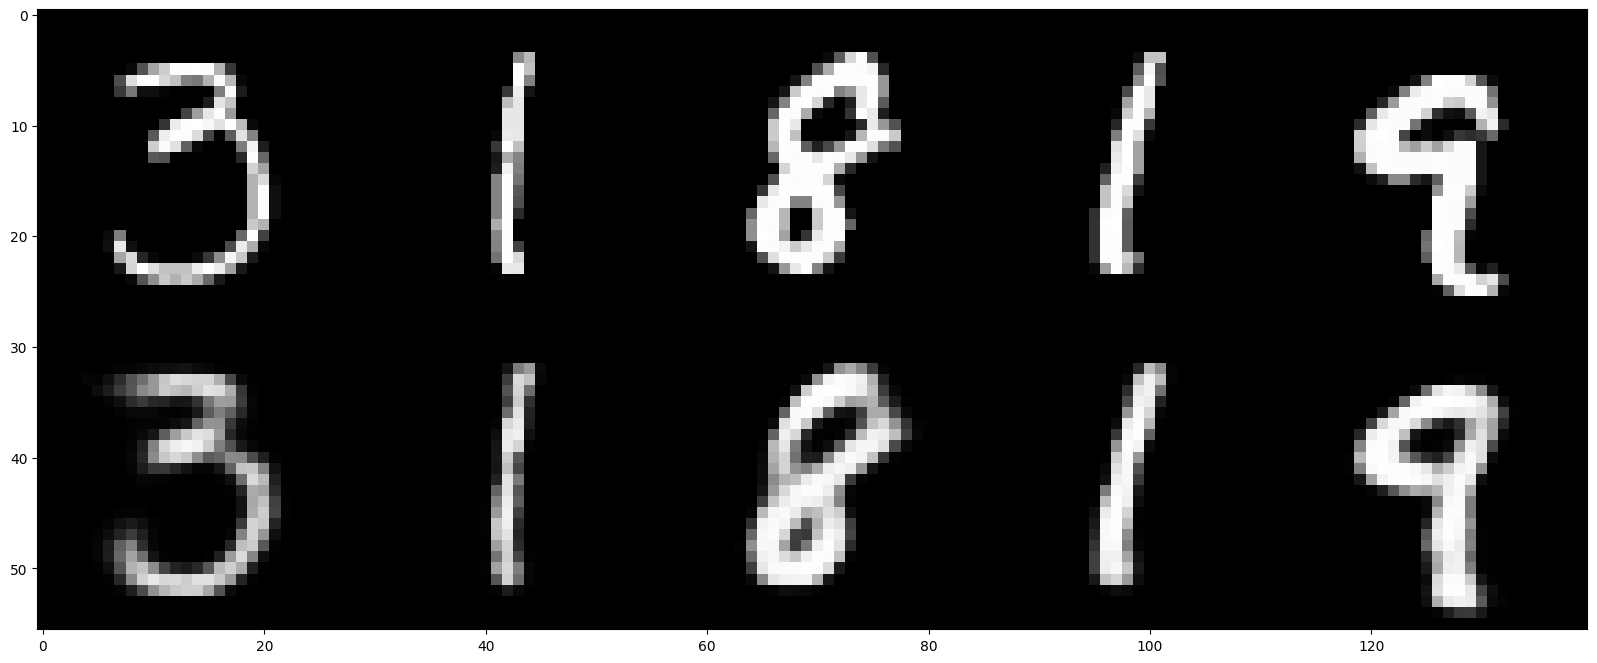

torch.Size([64, 1, 784])


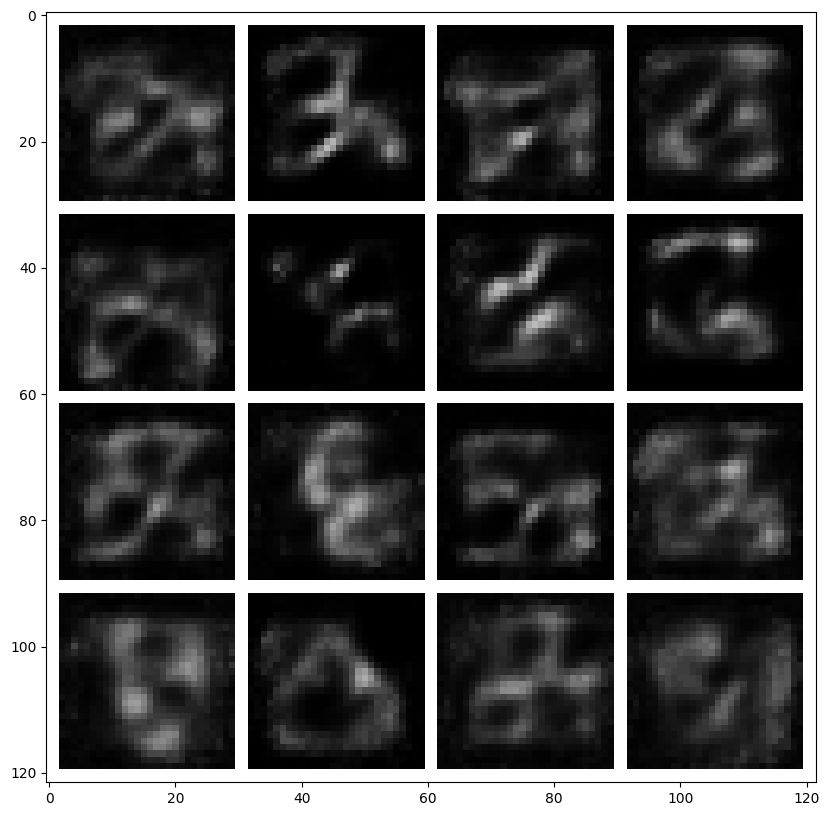

In [26]:
# visualize VAE reconstructions and samples from the generative model
vis_reconstruction(vae_model, randomize=True)
vis_samples(vae_model)

## Tweaking the loss function $\beta$ [2pt]
Prob1-6: Let's repeat the same experiment for $\beta = 10$, a very high value for the coefficient.

Running 5 epochs with beta=10
Run Epoch 0
It 0: Total Loss: 0.7864116430282593, 	 Rec Loss: 0.6930575966835022,	 KL Loss: 0.009335406124591827
It 100: Total Loss: 0.2729725241661072, 	 Rec Loss: 0.27219951152801514,	 KL Loss: 7.730236393399537e-05
It 200: Total Loss: 0.24546603858470917, 	 Rec Loss: 0.2448943853378296,	 KL Loss: 5.716603482142091e-05
It 300: Total Loss: 0.2642441689968109, 	 Rec Loss: 0.2636300027370453,	 KL Loss: 6.141657650005072e-05
It 400: Total Loss: 0.2668130397796631, 	 Rec Loss: 0.2660542130470276,	 KL Loss: 7.588131120428443e-05
It 500: Total Loss: 0.2554772198200226, 	 Rec Loss: 0.25484898686408997,	 KL Loss: 6.282409594859928e-05
It 600: Total Loss: 0.2552191913127899, 	 Rec Loss: 0.2546860873699188,	 KL Loss: 5.331050488166511e-05
It 700: Total Loss: 0.2731286287307739, 	 Rec Loss: 0.2725411355495453,	 KL Loss: 5.874929775018245e-05
It 800: Total Loss: 0.256966233253479, 	 Rec Loss: 0.25628170371055603,	 KL Loss: 6.845180178061128e-05
It 900: Total Loss: 0.

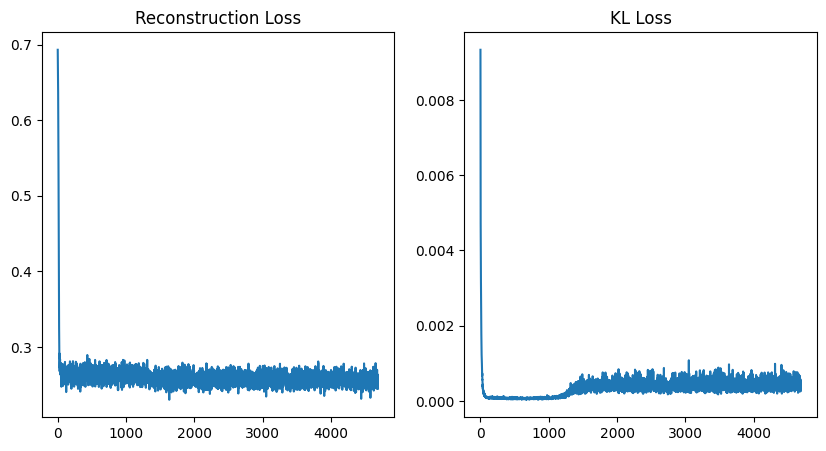

In [42]:
# VAE training loop
learning_rate = 1e-3
nz = 32
beta = 10

####################################### TODO #######################################
epochs = 5      # recommended 5-20 epochs
#################################### END TODO ######################################

# build VAE model
vae_model = VAE(nz, beta).to(device)    # transfer model to GPU if available
vae_model = vae_model.train()   # set model in train mode (eg batchnorm params get updated)

# build optimizer and loss function
####################################### TODO #######################################
# Build the optimizer for the vae_model. We will again use the Adam optimizer with #
# the given learning rate and otherwise default parameters.                        #
####################################################################################
# same as AE
optimizer = torch.optim.Adam(vae_model.parameters(), lr=learning_rate)
#################################### END TODO ######################################

train_it = 0
rec_loss, kl_loss = [], []
print(f"Running {epochs} epochs with {beta=}")
for ep in range(epochs):
    print("Run Epoch {}".format(ep))
    ####################################### TODO #######################################
    # Implement the main training loop for the VAE model.                              #
    # HINT: Your training loop should sample batches from the data loader, run the     #
    #       forward pass of the VAE, compute the loss, perform the backward pass and   #
    #       perform one gradient step with the optimizer.                              #
    # HINT: Don't forget to erase old gradients before performing the backward pass.   #
    # HINT: This time we will use the loss() function of our model for computing the   #
    #       training loss. It outputs the total training loss and a dict containing    #
    #       the breakdown of reconstruction and KL loss.                               #
    ####################################################################################
    for (sample_image, _) in mnist_data_loader:
        out = vae_model.forward(sample_image)
        vae_model.zero_grad()
        optimizer.zero_grad()
        total_loss, losses = vae_model.loss(sample_image, out)
        total_loss.backward()
        optimizer.step()
        rec_loss.append(losses['rec_loss']); kl_loss.append(losses['kl_loss'])
        if train_it % 100 == 0:
            print("It {}: Total Loss: {}, \t Rec Loss: {},\t KL Loss: {}"\
                .format(train_it, total_loss, losses['rec_loss'], losses['kl_loss']))
        train_it += 1
  #################################### END TODO ####################################

print("Done!")

rec_loss_plotdata = [foo.detach().cpu() for foo in rec_loss]
kl_loss_plotdata = [foo.detach().cpu() for foo in kl_loss]

# log the loss training curves
fig = plt.figure(figsize = (10, 5))   
ax1 = plt.subplot(121)
ax1.plot(rec_loss_plotdata)
ax1.title.set_text("Reconstruction Loss")
ax2 = plt.subplot(122)
ax2.plot(kl_loss_plotdata)
ax2.title.set_text("KL Loss")
plt.show()

>**Inline Question: What can you observe when setting $\beta = 0$ and $\beta = 10$? Explain your observations! [2pt]** 
>(max 200 words) 
>
>**Answer**:

## Obtaining the best $\beta$-factor [5pt]
Prob 1-6 continued: Now we can start tuning the beta value to achieve a good result. First describe what a "good result" would look like (focus what you would expect for reconstructions and sample quality). 

>**Inline Question: Characterize what properties you would expect for reconstructions and samples of a well-tuned VAE! [3pt]**
>(max 200 words)
>
>**Answer**: 
>

Now that you know what outcome we would like to obtain, try to tune $\beta$ to achieve this result. Logarithmic search in steps of 10x will be helpful, good results can be achieved after ~20 epochs of training. Training reconstructions should be high quality, test samples should be diverse, distinguishable numbers, most samples recognizable as numbers.

**Answer: Tuned beta value _______ [2pt]**

Running 10 epochs with beta=0
Beta: 1e-10
Run Epoch 0
It 0: Total Loss: 0.6927421689033508, 	 Rec Loss: 0.6927421689033508,	 KL Loss: 0.00953614804893732
It 100: Total Loss: 0.2347266972064972, 	 Rec Loss: 0.2347266972064972,	 KL Loss: 0.9256155490875244
It 200: Total Loss: 0.21379536390304565, 	 Rec Loss: 0.21379536390304565,	 KL Loss: 1.5989972352981567
It 300: Total Loss: 0.19516003131866455, 	 Rec Loss: 0.19516003131866455,	 KL Loss: 2.4631495475769043
It 400: Total Loss: 0.16221533715724945, 	 Rec Loss: 0.16221533715724945,	 KL Loss: 4.719267845153809
It 500: Total Loss: 0.1607052981853485, 	 Rec Loss: 0.1607052981853485,	 KL Loss: 6.554468154907227
It 600: Total Loss: 0.13321749866008759, 	 Rec Loss: 0.13321749866008759,	 KL Loss: 7.76168155670166
It 700: Total Loss: 0.14220286905765533, 	 Rec Loss: 0.14220286905765533,	 KL Loss: 9.030668258666992
It 800: Total Loss: 0.14211030304431915, 	 Rec Loss: 0.14211030304431915,	 KL Loss: 8.775861740112305
It 900: Total Loss: 0.1313741058

It 7800: Total Loss: 0.09239072352647781, 	 Rec Loss: 0.09239072352647781,	 KL Loss: 15.565032958984375
It 7900: Total Loss: 0.0895133689045906, 	 Rec Loss: 0.0895133689045906,	 KL Loss: 17.294530868530273
It 8000: Total Loss: 0.08933436870574951, 	 Rec Loss: 0.08933436870574951,	 KL Loss: 16.218395233154297
It 8100: Total Loss: 0.09042692929506302, 	 Rec Loss: 0.09042692929506302,	 KL Loss: 16.172304153442383
It 8200: Total Loss: 0.09147506207227707, 	 Rec Loss: 0.09147506207227707,	 KL Loss: 16.712135314941406
It 8300: Total Loss: 0.07988111674785614, 	 Rec Loss: 0.07988111674785614,	 KL Loss: 14.340616226196289
It 8400: Total Loss: 0.08978024125099182, 	 Rec Loss: 0.08978024125099182,	 KL Loss: 16.255094528198242
Run Epoch 9
It 8500: Total Loss: 0.09340181201696396, 	 Rec Loss: 0.09340181201696396,	 KL Loss: 15.6788911819458
It 8600: Total Loss: 0.0823412537574768, 	 Rec Loss: 0.0823412537574768,	 KL Loss: 15.926713943481445
It 8700: Total Loss: 0.08723420649766922, 	 Rec Loss: 0.08

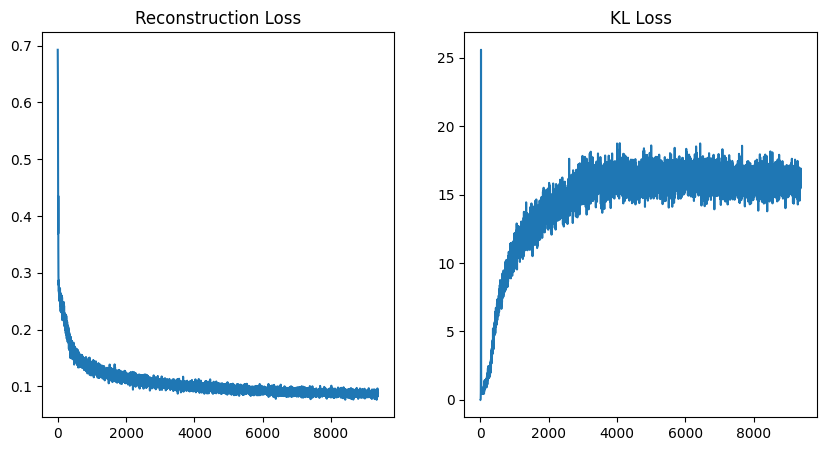

Beta: 1e-07
Run Epoch 0
It 0: Total Loss: 0.6938893795013428, 	 Rec Loss: 0.6938893795013428,	 KL Loss: 0.01134321466088295
It 100: Total Loss: 0.254167377948761, 	 Rec Loss: 0.25416722893714905,	 KL Loss: 1.3524531126022339
It 200: Total Loss: 0.20919166505336761, 	 Rec Loss: 0.2091914266347885,	 KL Loss: 2.4175000190734863
It 300: Total Loss: 0.17196419835090637, 	 Rec Loss: 0.17196382582187653,	 KL Loss: 3.7473480701446533
It 400: Total Loss: 0.1764257252216339, 	 Rec Loss: 0.17642518877983093,	 KL Loss: 5.42189359664917
It 500: Total Loss: 0.16706915199756622, 	 Rec Loss: 0.1670684963464737,	 KL Loss: 6.62053918838501
It 600: Total Loss: 0.1534813791513443, 	 Rec Loss: 0.15348057448863983,	 KL Loss: 8.049569129943848
It 700: Total Loss: 0.1505657583475113, 	 Rec Loss: 0.15056483447551727,	 KL Loss: 9.189033508300781
It 800: Total Loss: 0.13639578223228455, 	 Rec Loss: 0.13639482855796814,	 KL Loss: 9.56179141998291
It 900: Total Loss: 0.1266445815563202, 	 Rec Loss: 0.1266435682773

It 7900: Total Loss: 0.09006887674331665, 	 Rec Loss: 0.09006735682487488,	 KL Loss: 15.172937393188477
It 8000: Total Loss: 0.08872672915458679, 	 Rec Loss: 0.08872506767511368,	 KL Loss: 16.628171920776367
It 8100: Total Loss: 0.091523677110672, 	 Rec Loss: 0.09152206033468246,	 KL Loss: 16.153451919555664
It 8200: Total Loss: 0.09265539050102234, 	 Rec Loss: 0.09265374392271042,	 KL Loss: 16.483177185058594
It 8300: Total Loss: 0.08751510083675385, 	 Rec Loss: 0.0875135138630867,	 KL Loss: 15.870955467224121
It 8400: Total Loss: 0.08669965714216232, 	 Rec Loss: 0.0866980254650116,	 KL Loss: 16.312166213989258
Run Epoch 9
It 8500: Total Loss: 0.08776718378067017, 	 Rec Loss: 0.08776553720235825,	 KL Loss: 16.492158889770508
It 8600: Total Loss: 0.08285008370876312, 	 Rec Loss: 0.08284851163625717,	 KL Loss: 15.695284843444824
It 8700: Total Loss: 0.08702551573514938, 	 Rec Loss: 0.08702392876148224,	 KL Loss: 15.866557121276855
It 8800: Total Loss: 0.08515161275863647, 	 Rec Loss: 0.

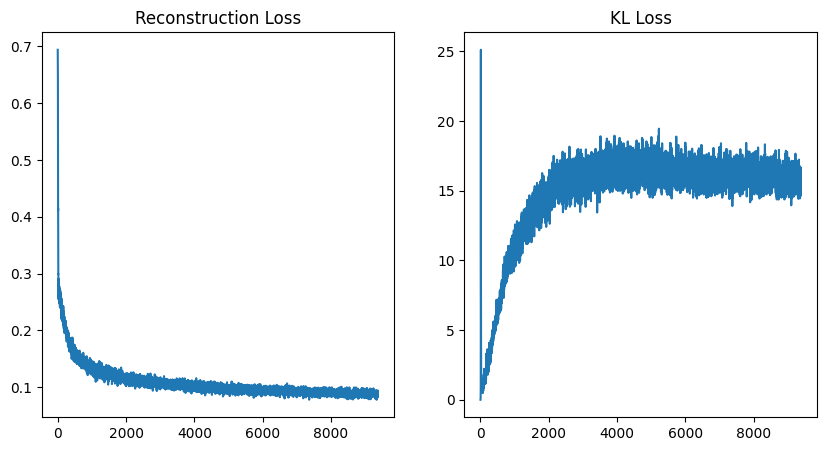

Beta: 1e-05
Run Epoch 0
It 0: Total Loss: 0.6934241056442261, 	 Rec Loss: 0.6934239864349365,	 KL Loss: 0.012014580890536308
It 100: Total Loss: 0.25927746295928955, 	 Rec Loss: 0.2592656910419464,	 KL Loss: 1.1768420934677124
It 200: Total Loss: 0.2110947221517563, 	 Rec Loss: 0.2110719084739685,	 KL Loss: 2.2816638946533203
It 300: Total Loss: 0.1931459605693817, 	 Rec Loss: 0.19311200082302094,	 KL Loss: 3.3962182998657227
It 400: Total Loss: 0.158272385597229, 	 Rec Loss: 0.1582198143005371,	 KL Loss: 5.256640434265137
It 500: Total Loss: 0.1603536754846573, 	 Rec Loss: 0.16029644012451172,	 KL Loss: 5.723966121673584
It 600: Total Loss: 0.15645311772823334, 	 Rec Loss: 0.15638485550880432,	 KL Loss: 6.826607704162598
It 700: Total Loss: 0.15780256688594818, 	 Rec Loss: 0.15772777795791626,	 KL Loss: 7.478392601013184
It 800: Total Loss: 0.1397998034954071, 	 Rec Loss: 0.13971343636512756,	 KL Loss: 8.637358665466309
It 900: Total Loss: 0.13279618322849274, 	 Rec Loss: 0.1327047348

It 7900: Total Loss: 0.09157173335552216, 	 Rec Loss: 0.09147581458091736,	 KL Loss: 9.591971397399902
It 8000: Total Loss: 0.09023715555667877, 	 Rec Loss: 0.09014317393302917,	 KL Loss: 9.398200035095215
It 8100: Total Loss: 0.08685045689344406, 	 Rec Loss: 0.08676086366176605,	 KL Loss: 8.95916748046875
It 8200: Total Loss: 0.08954999595880508, 	 Rec Loss: 0.08945067971944809,	 KL Loss: 9.931445121765137
It 8300: Total Loss: 0.08803451806306839, 	 Rec Loss: 0.0879426896572113,	 KL Loss: 9.182992935180664
It 8400: Total Loss: 0.09745714068412781, 	 Rec Loss: 0.09736547619104385,	 KL Loss: 9.166632652282715
Run Epoch 9
It 8500: Total Loss: 0.08682739734649658, 	 Rec Loss: 0.08674214780330658,	 KL Loss: 8.524991035461426
It 8600: Total Loss: 0.08825758844614029, 	 Rec Loss: 0.0881631001830101,	 KL Loss: 9.449151039123535
It 8700: Total Loss: 0.09034516662359238, 	 Rec Loss: 0.09025111794471741,	 KL Loss: 9.404953956604004
It 8800: Total Loss: 0.08848632872104645, 	 Rec Loss: 0.08838774

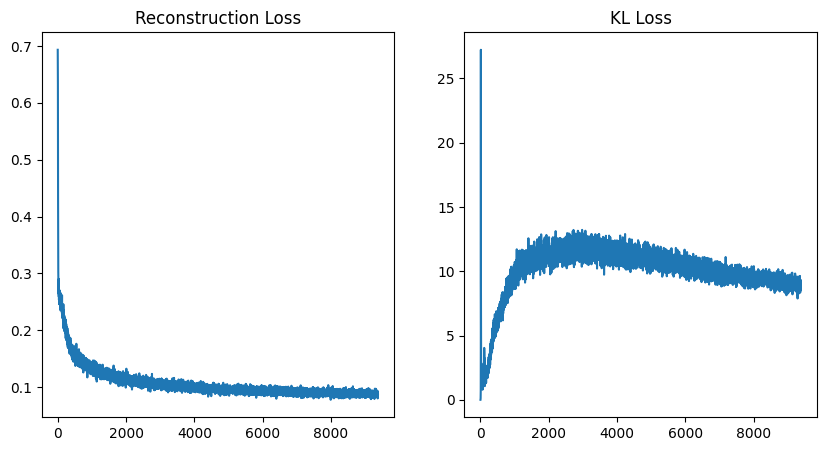

Beta: 0.0001
Run Epoch 0
It 0: Total Loss: 0.6946330666542053, 	 Rec Loss: 0.6946322321891785,	 KL Loss: 0.008454907685518265
It 100: Total Loss: 0.26136308908462524, 	 Rec Loss: 0.26130807399749756,	 KL Loss: 0.5501723885536194
It 200: Total Loss: 0.21531398594379425, 	 Rec Loss: 0.2151554971933365,	 KL Loss: 1.584837794303894
It 300: Total Loss: 0.16295281052589417, 	 Rec Loss: 0.16265447437763214,	 KL Loss: 2.983435869216919
It 400: Total Loss: 0.15895962715148926, 	 Rec Loss: 0.15853774547576904,	 KL Loss: 4.218836784362793
It 500: Total Loss: 0.16152408719062805, 	 Rec Loss: 0.1610518991947174,	 KL Loss: 4.721832752227783
It 600: Total Loss: 0.14860504865646362, 	 Rec Loss: 0.14809317886829376,	 KL Loss: 5.118643760681152
It 700: Total Loss: 0.13800004124641418, 	 Rec Loss: 0.13747932016849518,	 KL Loss: 5.207245826721191
It 800: Total Loss: 0.14585411548614502, 	 Rec Loss: 0.14530174434185028,	 KL Loss: 5.5236921310424805
It 900: Total Loss: 0.1413596272468567, 	 Rec Loss: 0.1408

It 7900: Total Loss: 0.09525012969970703, 	 Rec Loss: 0.09480329602956772,	 KL Loss: 4.468317031860352
It 8000: Total Loss: 0.09456570446491241, 	 Rec Loss: 0.09409250319004059,	 KL Loss: 4.732018947601318
It 8100: Total Loss: 0.08301061391830444, 	 Rec Loss: 0.08258778601884842,	 KL Loss: 4.228313446044922
It 8200: Total Loss: 0.08634328097105026, 	 Rec Loss: 0.08589109033346176,	 KL Loss: 4.521927356719971
It 8300: Total Loss: 0.0954025611281395, 	 Rec Loss: 0.09493719041347504,	 KL Loss: 4.653682231903076
It 8400: Total Loss: 0.08819081634283066, 	 Rec Loss: 0.08770586550235748,	 KL Loss: 4.849536895751953
Run Epoch 9
It 8500: Total Loss: 0.09224913269281387, 	 Rec Loss: 0.0917743369936943,	 KL Loss: 4.7479376792907715
It 8600: Total Loss: 0.0853768140077591, 	 Rec Loss: 0.08492425829172134,	 KL Loss: 4.5255279541015625
It 8700: Total Loss: 0.08726049959659576, 	 Rec Loss: 0.0867873877286911,	 KL Loss: 4.7311201095581055
It 8800: Total Loss: 0.08486267924308777, 	 Rec Loss: 0.084385

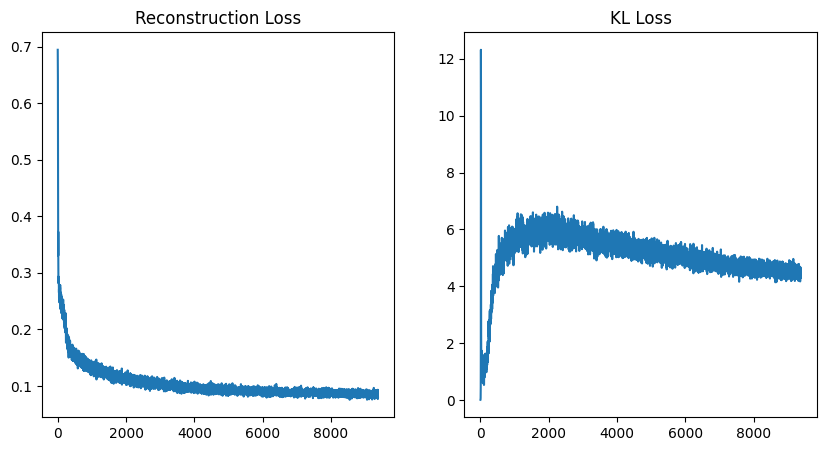

Beta: 0.001
Run Epoch 0
It 0: Total Loss: 0.6923342347145081, 	 Rec Loss: 0.6923248767852783,	 KL Loss: 0.009335469454526901
It 100: Total Loss: 0.25161030888557434, 	 Rec Loss: 0.25104618072509766,	 KL Loss: 0.564123272895813
It 200: Total Loss: 0.22653232514858246, 	 Rec Loss: 0.22577957808971405,	 KL Loss: 0.7527453899383545
It 300: Total Loss: 0.19407902657985687, 	 Rec Loss: 0.19279898703098297,	 KL Loss: 1.2800371646881104
It 400: Total Loss: 0.16297149658203125, 	 Rec Loss: 0.16127991676330566,	 KL Loss: 1.6915736198425293
It 500: Total Loss: 0.16093644499778748, 	 Rec Loss: 0.1593748778104782,	 KL Loss: 1.561572790145874
It 600: Total Loss: 0.14381645619869232, 	 Rec Loss: 0.1422104835510254,	 KL Loss: 1.605967402458191
It 700: Total Loss: 0.14794610440731049, 	 Rec Loss: 0.14611873030662537,	 KL Loss: 1.8273812532424927
It 800: Total Loss: 0.14728809893131256, 	 Rec Loss: 0.14549484848976135,	 KL Loss: 1.7932566404342651
It 900: Total Loss: 0.12710221111774445, 	 Rec Loss: 0.1

It 7900: Total Loss: 0.09594680368900299, 	 Rec Loss: 0.09402333199977875,	 KL Loss: 1.9234678745269775
It 8000: Total Loss: 0.09094825387001038, 	 Rec Loss: 0.08902588486671448,	 KL Loss: 1.9223724603652954
It 8100: Total Loss: 0.08723387867212296, 	 Rec Loss: 0.0854041799902916,	 KL Loss: 1.829701542854309
It 8200: Total Loss: 0.08889580518007278, 	 Rec Loss: 0.0869864821434021,	 KL Loss: 1.9093225002288818
It 8300: Total Loss: 0.09217260032892227, 	 Rec Loss: 0.09035700559616089,	 KL Loss: 1.8155925273895264
It 8400: Total Loss: 0.08463889360427856, 	 Rec Loss: 0.08277890831232071,	 KL Loss: 1.8599880933761597
Run Epoch 9
It 8500: Total Loss: 0.0900220274925232, 	 Rec Loss: 0.08807431161403656,	 KL Loss: 1.947713017463684
It 8600: Total Loss: 0.09303233027458191, 	 Rec Loss: 0.09116803109645844,	 KL Loss: 1.8642969131469727
It 8700: Total Loss: 0.09177481383085251, 	 Rec Loss: 0.08982045203447342,	 KL Loss: 1.9543594121932983
It 8800: Total Loss: 0.08605979382991791, 	 Rec Loss: 0.0

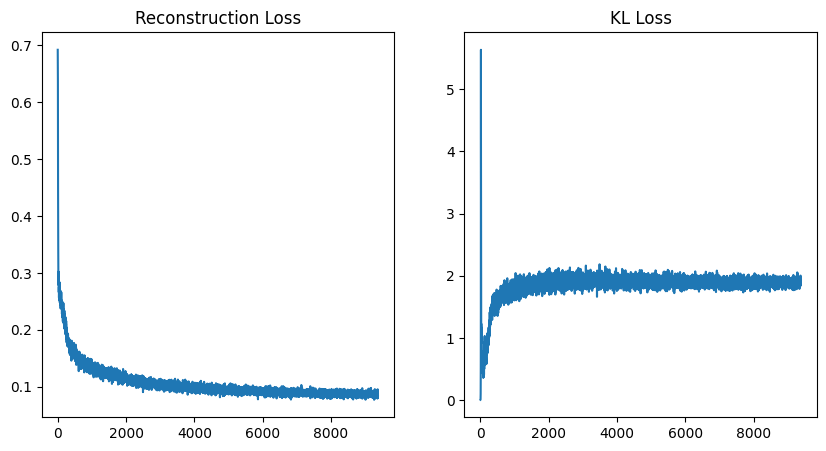

0
Done!


In [49]:
import math
# Tuning for best beta
learning_rate = 1e-3
nz = 32

####################################### TODO #######################################
epochs = 10      # recommended 5-20 epochs
beta = 0
betas = [1e-10, 1e-7, 1e-5, 1e-4, 1e-3] # Tune this for best results
#################################### END TODO ######################################

# build VAE model
vae_model = VAE(nz, beta).to(device)    # transfer model to GPU if available
vae_model = vae_model.train()   # set model in train mode (eg batchnorm params get updated)

# build optimizer and loss function
####################################### TODO #######################################
# Build the optimizer for the vae_model. We will again use the Adam optimizer with #
# the given learning rate and otherwise default parameters.                        #
####################################################################################
# same as AE

#################################### END TODO ######################################

best_loss = 10000
best_beta = 1e-5
best_model = vae_model

print(f"Running {epochs} epochs with {beta=}")
for b in betas:
    print("Beta: "+str(b))
    train_it = 0
    rec_loss, kl_loss = [], []
    vae_model = VAE(nz, b)
    optimizer = torch.optim.Adam(vae_model.parameters(), lr=learning_rate)
    vae_model = vae_model.train()   # set model in train mode (eg batchnorm params get updated)
    for ep in range(epochs):
        print("Run Epoch {}".format(ep))
    ####################################### TODO #######################################
    # Implement the main training loop for the VAE model.                              #
    # HINT: Your training loop should sample batches from the data loader, run the     #
    #       forward pass of the VAE, compute the loss, perform the backward pass and   #
    #       perform one gradient step with the optimizer.                              #
    # HINT: Don't forget to erase old gradients before performing the backward pass.   #
    # HINT: This time we will use the loss() function of our model for computing the   #
    #       training loss. It outputs the total training loss and a dict containing    #
    #       the breakdown of reconstruction and KL loss.                               #
    ####################################################################################
        for (sample_image, _) in mnist_data_loader:
            out = vae_model.forward(sample_image)
            vae_model.zero_grad()
            optimizer.zero_grad()
            total_loss, losses = vae_model.loss(sample_image, out)
            total_loss.backward()
            optimizer.step()
            rec_loss.append(losses['rec_loss']); kl_loss.append(losses['kl_loss'])
            if train_it % 100 == 0:
                print("It {}: Total Loss: {}, \t Rec Loss: {},\t KL Loss: {}"\
                    .format(train_it, total_loss, losses['rec_loss'], losses['kl_loss']))
            train_it += 1
        rec_loss.append(losses['rec_loss']); kl_loss.append(losses['kl_loss'])
        if train_it % 100 == 0:
            print("It {}: Total Loss: {}, \t Rec Loss: {},\t KL Loss: {}"\
                .format(train_it, total_loss, losses['rec_loss'], losses['kl_loss']))
        train_it += 1
    if best_loss > total_loss:
        best_loss = total_loss
        best_beta = beta
        best_model = vae_model
    rec_loss_plotdata = [foo.detach().cpu() for foo in rec_loss]
    kl_loss_plotdata = [foo.detach().cpu() for foo in kl_loss]
    # log the loss training curves
    fig = plt.figure(figsize = (10, 5))   
    ax1 = plt.subplot(121)
    ax1.plot(rec_loss_plotdata)
    ax1.title.set_text("Reconstruction Loss")
    ax2 = plt.subplot(122)
    ax2.plot(kl_loss_plotdata)
    ax2.title.set_text("KL Loss")
    plt.show()
    #################################### END TODO ####################################
print(best_beta)
print("Done!")



In [50]:
print(best_beta)
print(best_loss)

0
tensor(0.0813, grad_fn=<AddBackward0>)


# 4. Embedding Space Interpolation [3pt]

As mentioned in the introduction, AEs and VAEs cannot only be used to generate images, but also to learn low-dimensional representations of their inputs. In this final section we will investigate the representations we learned with both models by **interpolating in embedding space** between different images. We will encode two images into their low-dimensional embedding representations, then interpolate these embeddings and reconstruct the result.

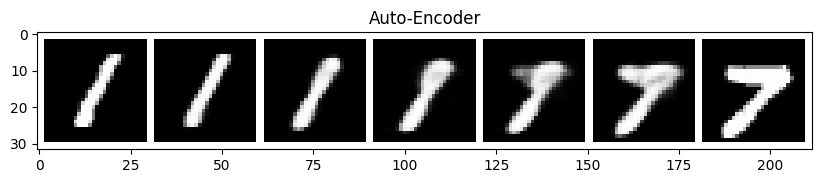

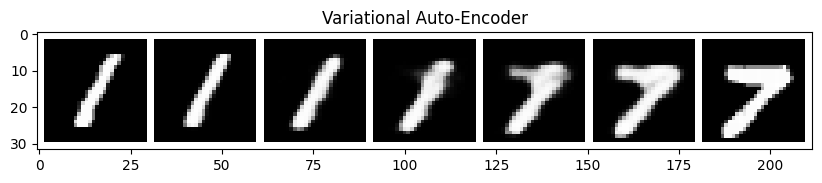

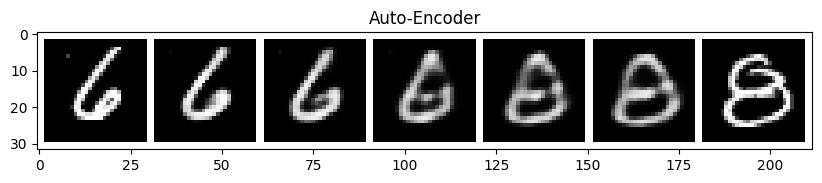

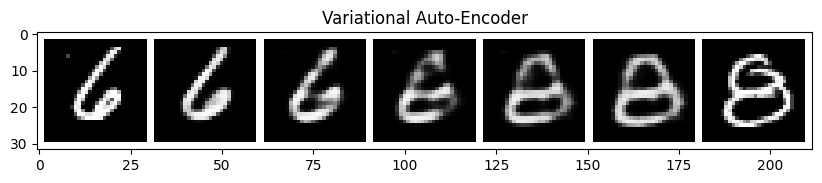

In [51]:
# Prob1-7
nz=32

def get_image_with_label(target_label):
  """Returns a random image from the training set with the requested digit."""
  for img_batch, label_batch in mnist_data_loader:
    for img, label in zip(img_batch, label_batch):
      if label == target_label:
        return img.to(device)

def interpolate_and_visualize(model, tag, start_img, end_img):
  """Encodes images and performs interpolation. Displays decodings."""
  model.eval()    # put model in eval mode to avoid updating batchnorm

  # encode both images into embeddings (use posterior mean for interpolation)
  z_start = model.encoder(start_img[None].reshape(1,784))[..., :nz]
  z_end = model.encoder(end_img[None].reshape(1,784))[..., :nz]

  # compute interpolated latents
  N_INTER_STEPS = 5
  z_inter = [z_start + i/N_INTER_STEPS * (z_end - z_start) for i in range(N_INTER_STEPS)]

  # decode interpolated embeddings (as a single batch)
  img_inter = model.decoder(torch.cat(z_inter))
  img_inter = img_inter.reshape(-1, 28, 28)

  # reshape result and display interpolation
  vis_imgs = torch.cat([start_img, img_inter, end_img]).reshape(-1,1,28,28)
  fig = plt.figure(figsize = (10, 10))   
  ax1 = plt.subplot(111)
  ax1.imshow(torchvision.utils.make_grid(vis_imgs, nrow=N_INTER_STEPS+2, pad_value=1.)\
                  .data.cpu().numpy().transpose(1, 2, 0), cmap='gray')
  plt.title(tag)
  plt.show()


vae_model = best_model
### Interpolation 1
START_LABEL = 1
END_LABEL = 7
# sample two training images with given labels
start_img = get_image_with_label(START_LABEL)
end_img = get_image_with_label(END_LABEL)
# visualize interpolations for AE and VAE models
interpolate_and_visualize(ae_model, "Auto-Encoder", start_img, end_img)
interpolate_and_visualize(vae_model, "Variational Auto-Encoder", start_img, end_img)

### Interpolation 2
START_LABEL = 6
END_LABEL = 8
# sample two training images with given labels
start_img = get_image_with_label(START_LABEL)
end_img = get_image_with_label(END_LABEL)
# visualize interpolations for AE and VAE models
interpolate_and_visualize(ae_model, "Auto-Encoder", start_img, end_img)
interpolate_and_visualize(vae_model, "Variational Auto-Encoder", start_img, end_img)


Repeat the experiment for different start / end labels and different samples. Describe your observations.

>**Prob1-7 continued: Inline Question: Repeat the interpolation experiment with different start / end labels and multiple samples. Describe your observations! [2 pt]**
>  1. How do AE and VAE embedding space interpolations differ?
>  2. How do you expect these differences to affect the usefulness of the learned representation for downstream learning?
>(max 300 words)
>
>**Answer**:
>

# 5. Conditional VAE
Let us now try a Conditional VAE
Now we will try to create a [Conditional VAE](https://proceedings.neurips.cc/paper/2014/file/d523773c6b194f37b938d340d5d02232-Paper.pdf), where we can condition the encoder and decoder of the VAE on the label `c`. 

## Defining the conditional Encoder, Decoder, and VAE models [5 pt]

Prob1-8. We create a separate encoder and decoder class that take in an additional argument `c` in their forward pass, and then build our CVAE model on top of it. Note that the encoder and decoder just need to append `c` to the standard inputs to these modules.

In [133]:
def idx2onehot(idx, n):
    """Converts a batch of indices to a one-hot representation."""
    assert torch.max(idx).item() < n
    if idx.dim() == 1:
        idx = idx.unsqueeze(1)
    onehot = torch.zeros(idx.size(0), n).to(idx.device)
    onehot.scatter_(1, idx, 1)

    return onehot

# Let's define encoder and decoder networks

class CVAEEncoder(nn.Module):
  def __init__(self, nz, input_size, conditional, num_labels):
    super().__init__()
    self.input_size = input_size + num_labels if conditional else input_size
    self.num_labels = num_labels
    self.conditional = conditional

    ################################# TODO #########################################
    # Create the network architecture using a nn.Sequential module wrapper.        #
    # Encoder Architecture:                                                        #
    # - input_size -> 256                                                          #
    # - ReLU                                                                       #
    # - 256 -> 64                                                                  #
    # - ReLU                                                                       #
    # - 64 -> nz                                                                   #
    # HINT: Verify the shapes of intermediate layers by running partial networks   #
    #        (with the next notebook cell) and visualizing the output shapes.      #
    ################################################################################
    self.net = nn.Sequential(
    nn.Linear(self.input_size, 256),
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Linear(64, nz))
    ################################ END TODO ######################################

  def forward(self, x, c=None):
    ################################# TODO #########################################
    # If using conditional VAE, concatenate x and a onehot version of c to create  #
    # the full input. Use function idx2onehot above.                               #
    ################################################################################
    if self.conditional == True:
        onehot = idx2onehot(c, self.num_labels)
        #print(onehot.shape, x.shape)
        x = torch.concat((x, onehot), 1)
        #print(x.shape)
    ################################################################################
    return self.net(x)


class CVAEDecoder(nn.Module):
  def __init__(self, nz, output_size, conditional, num_labels):
    super().__init__()
    self.output_size = output_size
    self.conditional = conditional
    self.num_labels = num_labels
    if self.conditional:
        nz = nz + num_labels
    ################################# TODO #########################################
    # Create the network architecture using a nn.Sequential module wrapper.        #
    # Decoder Architecture (mirrors encoder architecture):                         #
    # - nz -> 64                                                                   #
    # - ReLU                                                                       #
    # - 64 -> 256                                                                  #
    # - ReLU                                                                       #
    # - 256 -> output_size                                                         #
    ################################################################################
    self.net = nn.Sequential(
    nn.Linear(nz, 64),
    nn.ReLU(),
    nn.Linear(64, 256),
    nn.ReLU(),
    nn.Linear(256, self.output_size),
    nn.Sigmoid())
    ################################ END TODO #######################################

  def forward(self, z, c=None):
    ################################# TODO #########################################
    # If using conditional VAE, concatenate z and a onehot version of c to create  #
    # the full embedding. Use function idx2onehot above.                           #
    ################################################################################
    if self.conditional == True:
        onehot = idx2onehot(c, self.num_labels)
        #print(onehot.shape)
        z = torch.concat((z, onehot), 1)
    out = self.net(z).reshape(-1, 1, self.output_size)
    #print(out.shape)
    ################################ END TODO #######################################

    return out


class CVAE(nn.Module):
    def __init__(self, nz, beta=1.0, conditional=False, num_labels=0):
        super().__init__()
        if conditional:
            assert num_labels > 0
        self.beta = beta
        self.encoder = CVAEEncoder(2*nz, input_size=in_size, conditional=conditional, num_labels=num_labels)
        self.decoder = CVAEDecoder(nz, output_size=out_size, conditional=conditional, num_labels=num_labels)

    def forward(self, x, c=None):
        if x.dim() > 2:
            x = x.view(-1, 28*28)

        q = self.encoder(x,c)
        mu, log_sigma = torch.chunk(q, 2, dim=-1)

        # sample latent variable z with reparametrization
        eps = torch.normal(mean=torch.zeros_like(mu), std=torch.ones_like(log_sigma))
        # eps = torch.randn_like(mu) # Alternatively use this
        z = mu + eps * torch.exp(log_sigma)

        # compute reconstruction
        reconstruction = self.decoder(z, c)

        return {'q': q, 'rec': reconstruction, 'c': c}

    def loss(self, x, outputs):
        ####################################### TODO #######################################
        # Implement the loss computation of the VAE.                                       #
        # HINT: Your code should implement the following steps:                            #
        #          1. compute the image reconstruction loss, similar to AE loss above      #
        #          2. compute the KL divergence loss between the inferred posterior        #
        #             distribution and a unit Gaussian prior; you can use the provided     #
        #             function above for computing the KL divergence between two Gaussians #
        #             parametrized by mean and log_sigma                                   #
        # HINT: Make sure to compute the KL divergence in the correct order since it is    #
        #       not symmetric!!  ie. KL(p, q) != KL(q, p)                                  #
        ####################################################################################
        rec, q = outputs['rec'], outputs['q']
        #print(rec.shape, x.shape)
        x = x.reshape(rec.shape)
        rec_loss = torch.nn.functional.binary_cross_entropy(rec, x)
        m, sig = q[:, :nz],q[:, nz:]
        m1, sig1 = torch.zeros_like(q[:, :nz]), torch.zeros_like(q[:, nz:])
        kl_loss = torch.mean(kl_divergence(m ,sig, m1, sig1))
        #################################### END TODO ######################################

        # return weighted objective
        return rec_loss + self.beta * kl_loss, \
            {'rec_loss': rec_loss, 'kl_loss': kl_loss}
    
    def reconstruct(self, x, c=None):
        """Use mean of posterior estimate for visualization reconstruction."""
        ####################################### TODO #######################################
        # This function is used for visualizing reconstructions of our VAE model. To       #
        # obtain the maximum likelihood estimate we bypass the sampling procedure of the   #
        # inferred latent and instead directly use the mean of the inferred posterior.     #
        # HINT: encode the input image and then decode the mean of the posterior to obtain #
        #       the reconstruction.                                                        #
        ####################################################################################
        q = self.encoder(x)
        q = q.reshape(-1, 1, nz)
        reconstruction = self.decoder(q)
        image = reconstruction.reshape(-1, 28, 28)
        #################################### END TODO ######################################
        return image

## Setting up the CVAE Training loop

Running 5 epochs with beta=0.1
Run Epoch 0
It 0: Total Loss: 0.6944566965103149, 	 Rec Loss: 0.6937538981437683,	 KL Loss: 0.007027770858258009
It 100: Total Loss: 0.25910481810569763, 	 Rec Loss: 0.2561229467391968,	 KL Loss: 0.029818812385201454
It 200: Total Loss: 0.24576014280319214, 	 Rec Loss: 0.24033978581428528,	 KL Loss: 0.05420364439487457
It 300: Total Loss: 0.22773781418800354, 	 Rec Loss: 0.21945014595985413,	 KL Loss: 0.08287673443555832
It 400: Total Loss: 0.21906504034996033, 	 Rec Loss: 0.20889928936958313,	 KL Loss: 0.10165749490261078
It 500: Total Loss: 0.2245500236749649, 	 Rec Loss: 0.21223978698253632,	 KL Loss: 0.12310235947370529
It 600: Total Loss: 0.21203722059726715, 	 Rec Loss: 0.19762548804283142,	 KL Loss: 0.14411726593971252
It 700: Total Loss: 0.2080303430557251, 	 Rec Loss: 0.19340923428535461,	 KL Loss: 0.14621111750602722
It 800: Total Loss: 0.20699959993362427, 	 Rec Loss: 0.19242680072784424,	 KL Loss: 0.1457280069589615
It 900: Total Loss: 0.19822

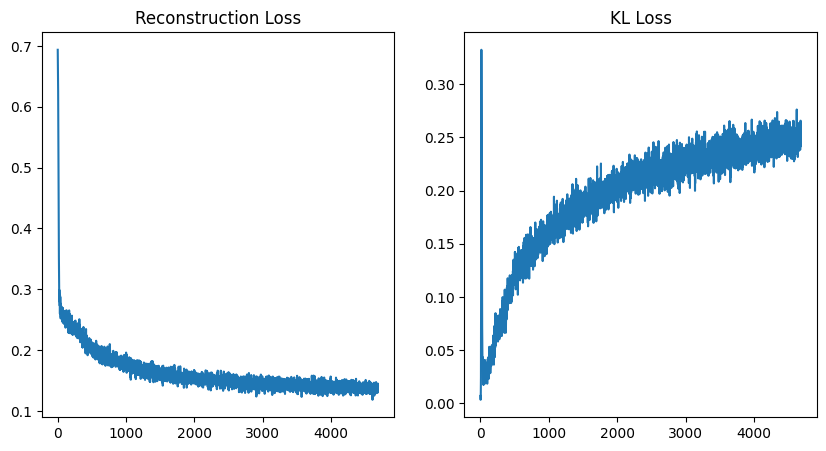

In [136]:
learning_rate = 1e-3
nz = 32

####################################### TODO #######################################
# Tune the beta parameter to obtain good training results. However, for the    #
# initial experiments leave beta = 0 in order to verify our implementation.        #
####################################################################################
epochs = 5 # works with fewer epochs than AE, VAE. we only test conditional samples.
beta = 0.1
#################################### END TODO ######################################

# build CVAE model
conditional = True
cvae_model = CVAE(nz, beta, conditional=conditional, num_labels=10).to(device)    # transfer model to GPU if available
cvae_model = cvae_model.train()   # set model in train mode (eg batchnorm params get updated)

# build optimizer and loss function
####################################### TODO #######################################
# Build the optimizer for the cvae_model. We will again use the Adam optimizer with #
# the given learning rate and otherwise default parameters.                        #
####################################################################################
optimizer = torch.optim.Adam(cvae_model.parameters(), lr=learning_rate)
# same as AE
#################################### END TODO ######################################

train_it = 0
rec_loss, kl_loss = [], []
print(f"Running {epochs} epochs with {beta=}")
for ep in range(epochs):
    print(f"Run Epoch {ep}")
    ####################################### TODO #######################################
    # Implement the main training loop for the model.                                  #
    # If using conditional VAE, remember to pass the conditional variable c to the     #
    # forward pass                                                                     #
    # HINT: Your training loop should sample batches from the data loader, run the     #
    #       forward pass of the model, compute the loss, perform the backward pass and #
    #       perform one gradient step with the optimizer.                              #
    # HINT: Don't forget to erase old gradients before performing the backward pass.   #
    # HINT: As before, we will use the loss() function of our model for computing the  #
    #       training loss. It outputs the total training loss and a dict containing    #
    #       the breakdown of reconstruction and KL loss.                               #
    ####################################################################################
    for (sample_image, sample_labels) in mnist_data_loader:
        #print(sample_labels)
        out = cvae_model.forward(sample_image, sample_labels)
        cvae_model.zero_grad()
        optimizer.zero_grad()
        total_loss, losses = cvae_model.loss(sample_image, out)
        total_loss.backward()
        optimizer.step()
        rec_loss.append(losses['rec_loss']); kl_loss.append(losses['kl_loss'])
        if train_it % 100 == 0:
            print("It {}: Total Loss: {}, \t Rec Loss: {},\t KL Loss: {}"\
                .format(train_it, total_loss, losses['rec_loss'], losses['kl_loss']))
        train_it += 1
  #################################### END TODO ####################################

print("Done!")

rec_loss_plotdata = [foo.detach().cpu() for foo in rec_loss]
kl_loss_plotdata = [foo.detach().cpu() for foo in kl_loss]

# log the loss training curves
fig = plt.figure(figsize = (10, 5))
ax1 = plt.subplot(121)
ax1.plot(rec_loss_plotdata)
ax1.title.set_text("Reconstruction Loss")
ax2 = plt.subplot(122)
ax2.plot(kl_loss_plotdata)
ax2.title.set_text("KL Loss")
plt.show()

### Verifying conditional samples from CVAE [6 pt]
Now let us generate samples from the trained model, conditioned on all the labels.

<Figure size 640x480 with 0 Axes>

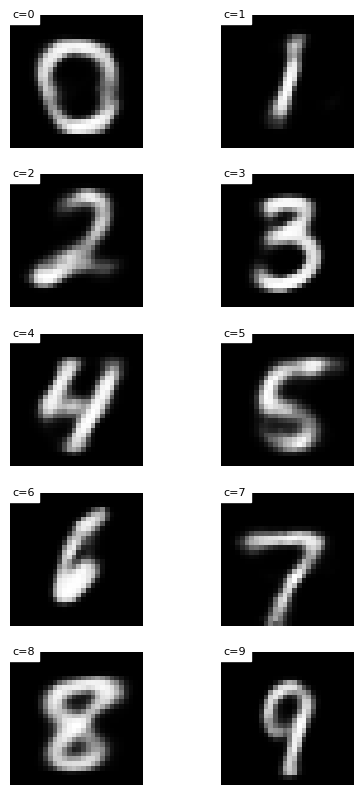

In [137]:
# Prob1-9
if conditional:
    c = torch.arange(0, 10).long().unsqueeze(1).to(device)
    z = torch.randn([10, nz]).to(device)
    x = cvae_model.decoder(z, c=c)
else:
    z = torch.randn([10, nz]).to(device)
    x = cvae_model.decoder(z)

plt.figure()
plt.figure(figsize=(5, 10))
for p in range(10):
    plt.subplot(5, 2, p+1)
    if conditional:
        plt.text(
            0, 0, "c={:d}".format(c[p].item()), color='black',
            backgroundcolor='white', fontsize=8)
    plt.imshow(x[p].view(28, 28).cpu().data.numpy(), cmap='gray')
    plt.axis('off')

# Submission Instructions

You need to submit this jupyter notebook and a PDF. See Piazza for detailed submission instructions.